In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from os import path

In [9]:
image_path = "D:\\Projekty\\szkolne\\psi-project-captcha\\rects\\sintegrarj\\1cwhi.png"
image = cv2.imread(image_path)

In [14]:
def intersectionArea(a, b):
    (x1, y1, w1, h1) = a
    (x2, y2, w2, h2) = b

    dx = max(min(x1 + w1, x2 + w2), max(x1, x2)) - min(min(x1 + w1, x2 + w2), max(x1, x2))
    dy = max(min(y1 + h1, y2 + h2), max(y1, x2)) - min(min(y1 + h1, y2 + h2), max(y1, x2))
    if (dx >= 0) and (dy >= 0):
        return dx * dy
        

In [17]:
def areAnyRegionsOverlapping(regions):
    for (i, region1) in enumerate(regions):
        for (j, region2) in enumerate(regions):
            if i == j:
                continue
            
            area1 = region1[2] * region1[3]
            area2 = region2[2] * region2[3]
            inter = intersectionArea(region1, region2)

            print(region1, region2, area1, area2, inter)
            print(region1)
            print(region1[0], region1[1])


            if inter is not None and (area1/inter < 3 or area2/inter < 3):
                return True

    return False

5 5
(42, 16, 11, 20) (77, 12, 26, 30) 220 780 984
(42, 16, 11, 20)
42 16
True


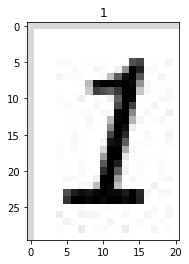

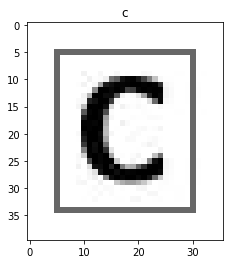

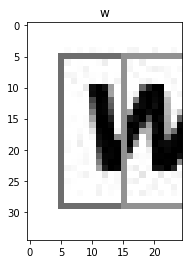

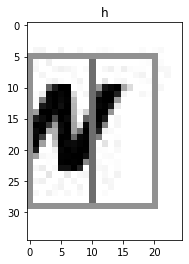

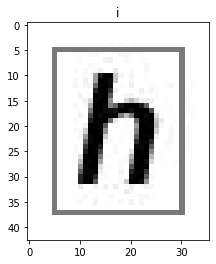

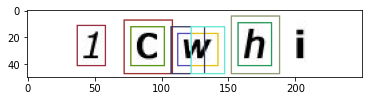

In [18]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# blur = cv2.medianBlur(gray, 1)
# blur = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, np.ones((2,2), np.uint8))
tr = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

contours = [ cv2.boundingRect(contour) for contour in cv2.findContours(tr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]]
contours = [ (x, y, w, h) for (x, y, w, h) in contours if w > 5 and h > 5 and w/h < 3 and h/w < 3]

regions = []

for (x, y, width, height) in contours:
    if width < 5 or height < 5 or width/height > 3 or height/width > 3:
        continue

    if width / height > 1.05:
        # This contour is too wide to be a single letter!
        # Split it in half into two letter regions!
        half_width = int(width / 2)
        regions.append((x, y, half_width, height))
        regions.append((x + half_width, y, half_width, height))
    else:
        # This is a normal letter by itself
        regions.append((x, y, width, height))

regions = sorted(regions, key=lambda x: x[0])

labels = path.basename(path.splitext(image_path)[0])

print(len(labels), len(regions))
print(areAnyRegionsOverlapping(regions))

margin = 5
rectangled = image.copy()
for ((x, y, width, height), label) in zip(regions, labels):
    letter = gray[max(y - margin, 0):y + height + margin, max(x - margin, 0):x + width + margin]

    actualHeight, actualWidth = letter.shape

    if len(letter) == 0 or actualWidth == 0 or actualHeight == 0:
        print("Letter skipped")
        continue

    if max(actualHeight, actualWidth)/min(actualHeight, actualWidth) > 3:
        print("Letter skipped due to invalid aspect ratio")
        continue
    
    plt.imshow(letter, cmap="gray")
    plt.title(label)
    plt.show()

    rectangled = cv2.rectangle(rectangled, (x - margin, y - margin), (x + margin + width, y + height + margin), list(np.random.random(size=3) * 256), 1)

plt.imshow(rectangled)